<a href="https://colab.research.google.com/github/nanddalal/sf-simulator/blob/main/sf_simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SF Simulator

This notebook can be used to simulate costs and number of attempts to get some desired SF for your equips. Here we assume you are starting with some unique equipment so that it is easy to transfer if it goes boom.

The main variables you should adjust before running this are in the second cell.
- `BASE_SF` : the starting star force of your equip. You might already have star forced up to some number or used a star force scroll from an event. So if your equip is already 15 SF, set `BASE_SF = 15`.
- `BASE_COST` : the cost of a level 1 unique from the trade station. When your equip goes boom, you have to buy a copy from the trade station. I was running this for muspel thief shoes, which were around 4mil, so I set `BASE_COST = 4000000`.
- `TARGET_SF` : the final desired SF for your equip. I need to get all my equips to SF 18 at the moment, so I set `TARGET_SF = 18`.

F2P can also make use of decline and destruction prevention scrolls from events, Kerning, etc, so it would be interesting to add that to this simulation as well...

In [1]:
BASE_SF = 0
BASE_COST = 4000000
TARGET_SF = 18

In [2]:
import random

import numpy as np
import pandas as pd

In [3]:
class Session(object):
    def __init__(self, base_sf, base_cost):
        df = pd.read_csv('rates.csv')
        self.rates_by_sf = {row['sf']: row for row in df.to_dict('records')}
        self.base_sf = base_sf
        self.base_cost = base_cost

    def _reset(self):
        self.curr_sf = self.base_sf
        self.curr_cost = 0

    def _hit(self):
        rates = self.rates_by_sf[self.curr_sf]
        self.curr_cost += rates['cost']
        prob = random.uniform(0, 1)
        if prob <= rates['success']:
            self.curr_sf += 1
        elif prob <= (rates['maintained'] + rates['success']):
            pass
        elif prob <= (rates['degraded'] + rates['maintained'] + rates['success']):
            self.curr_sf -= 1
        elif prob <= (rates['destroyed'] + rates['degraded'] + rates['maintained'] + rates['success']):
            self.curr_cost += self.base_cost
        else:
            raise ValueError(f'invalid case, prob : {prob}')

    def simulate(self, target_sf):
        self._reset()
        if target_sf < self.curr_sf:
            raise ValueError(f'target sf ({target_sf}) must be greater than base sf ({self.base_sf})')
        num_hits = 0
        while self.curr_sf != target_sf:
            self._hit()
            num_hits += 1
        result = {
            'cost': self.curr_cost,
            'hits': num_hits,
        }
        return result

In [4]:
def compute_bootstrap_batch(base_sf, base_cost, target_sf):
    session = Session(base_sf, base_cost)
    results = []
    for _ in range(1000): # num bootstrap samples
        result = session.simulate(target_sf)
        results.append(result)
    results = pd.DataFrame(results)
    return results

In [5]:
def compute_bootstrap_stepwise(base_sf, base_cost, target_sf):
    mean_results = []
    for base_sf in range(base_sf, target_sf):
        target_sf = base_sf + 1
        results = compute_bootstrap_batch(base_sf, base_cost, target_sf)
        mean_result = results.mean().to_dict()
        mean_result['target_sf'] = target_sf
        mean_results.append(mean_result)
    mean_results = pd.DataFrame(mean_results)
    return mean_results

cost    1.270115e+08
hits    9.235900e+01
dtype: float64

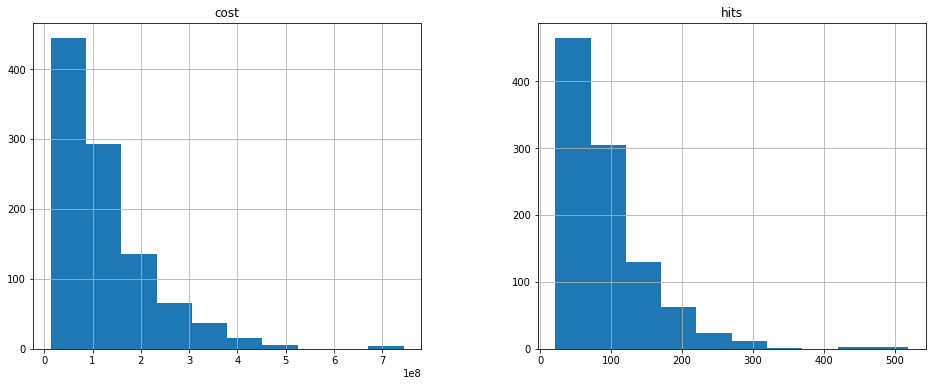

In [6]:
results = compute_bootstrap_batch(BASE_SF, BASE_COST, TARGET_SF)
results.hist(figsize=(16,6))
results.mean()

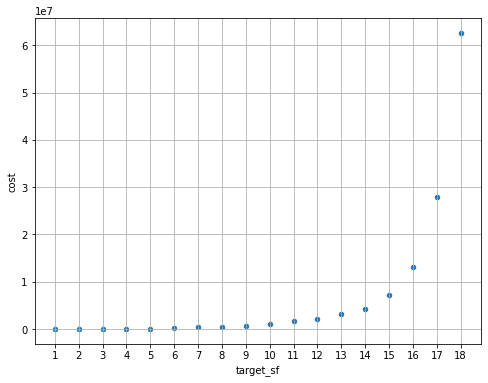

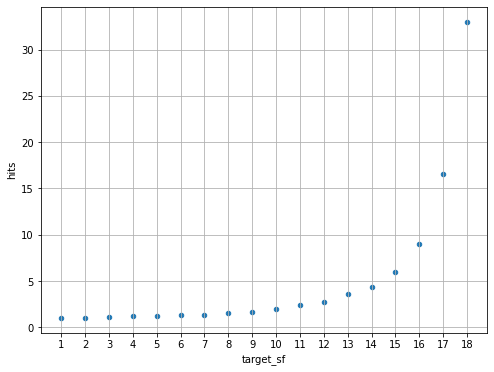

In [7]:
mean_results = compute_bootstrap_stepwise(BASE_SF, BASE_COST, TARGET_SF)
def plot_mean_result(y):
    mean_results.plot(x='target_sf', y=y, xticks=mean_results['target_sf'], kind='scatter', grid=True, figsize=(8,6))
plot_mean_result('cost')
plot_mean_result('hits')